# Training the electric network

Write a two-layer neural network to train image in raw format. The network is trained to predict the electric network from the image. The network is trained on the training set and evaluated on the test set. The network is trained using stochastic gradient descent with a fixed learning rate and no regularization.

In [1]:
# import the necessary packages
import torch as torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

# import raw image
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import os

## 1. have a feel of the raw image

In [2]:
def rawimage2tensor(raw_data, width=32, height=32):
    # create a PIL image from the raw data
    img = Image.frombytes('I;16', (width, height), raw_data, decoder_name='raw')

    # convert the PIL image to a numpy array
    image = np.array(img)

    # convert uint16 to int16
    image = image.astype(np.int16)

    # convert the numpy array to a tensor
    tensor = torch.from_numpy(image)

    # return the tensor
    return tensor

### 1.1 read the image

In [6]:
# # open the raw image file
# with open('test_image/pic_20231025_15 1 2_991.raw', 'rb') as f:
#     # read the raw image data
#     raw_data = f.read()

# initialize the dataset
dataset = []

# open the raw image file in folder '红外光测试'
for image in os.listdir('红外光测试/img32x32_20231023_113512_flight/'):
    with open('红外光测试/img32x32_20231023_113512_flight/' + image, 'rb') as f:
        # read the raw image data
        raw_data = f.read()
        matrix = rawimage2tensor(raw_data)
        label = 0  # 0 for flight
        # append the image tensor into dataset
        dataset.append((matrix, label))

for image in os.listdir('红外光测试/img32x32_20231023_113737_oil/'):
    with open('红外光测试/img32x32_20231023_113737_oil/' + image, 'rb') as f:
        # read the raw image data
        raw_data = f.read()
        matrix = rawimage2tensor(raw_data)
        label = 1  # 1 for oil-tank
        # append the image tensor into dataset
        dataset.append((matrix, label))

for image in os.listdir('红外光测试/img32x32_20231023_113921_boat/'):
    with open('红外光测试/img32x32_20231023_113921_boat/' + image, 'rb') as f:
        # read the raw image data
        raw_data = f.read()
        matrix = rawimage2tensor(raw_data)
        label = 2  # 2 for boat
        # append the image tensor into dataset
        dataset.append((matrix, label))

750
torch.Size([32, 32])
tensor([[4268, 4277, 4430,  ..., 5454, 4849, 3208],
        [6667, 6710, 7087,  ..., 7364, 6053, 3205],
        [6437, 6295, 6864,  ..., 5828, 4586, 3230],
        ...,
        [4858, 5170, 4752,  ..., 4095, 2901, 2748],
        [4840, 5028, 4715,  ..., 4387, 2953, 2824],
        [5001, 5118, 4673,  ..., 4204, 2941, 2878]], dtype=torch.int16) 0
tensor([[3093, 3141, 3113,  ..., 3373, 3531, 3130],
        [5696, 5946, 5944,  ..., 5403, 4834, 3227],
        [7764, 8151, 7958,  ..., 4892, 3996, 3195],
        ...,
        [4893, 5218, 4895,  ..., 5048, 2994, 2895],
        [5022, 5135, 4731,  ..., 5090, 2984, 3049],
        [5695, 5389, 4712,  ..., 5161, 3109, 2901]], dtype=torch.int16) 1
tensor([[3133, 3069, 3135,  ..., 3473, 3358, 2828],
        [4175, 4059, 4011,  ..., 4316, 3753, 2748],
        [4432, 4171, 4388,  ..., 3687, 3397, 2807],
        ...,
        [3567, 3836, 3459,  ..., 3144, 2628, 2567],
        [3515, 3587, 3400,  ..., 3240, 2666, 2670],
        

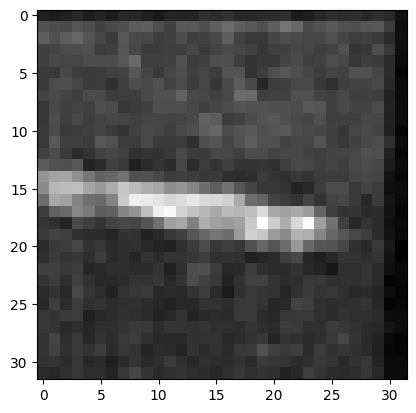

In [17]:
print(len(dataset))
print(dataset[0][0].shape)
# check a random sample in dataset
sample = dataset[0]
print(sample[0], sample[1])
plt.imshow(sample[0], cmap='gray')

sample = dataset[250]
print(sample[0], sample[1])
plt.imshow(sample[0], cmap='gray')

sample = dataset[500]
print(sample[0], sample[1])
plt.imshow(sample[0], cmap='gray')

## 2. make a dataset
3 kinds of objects in 3 folders, 250 raw images in each folder, labeled as 0, 1, 2.

`datasets.ImageFolder(root='./data', transform=transform)` do not support raw image, so we need to make a dataset by ourselves.

In [1]:

# define the path to the root folder of the dataset
root = '红外光测试'

# create the Image dataset with only raw images
dataset = datasets.ImageFolder(root=root, transform=transform, )

# print the class labels
print('dataset.class:', dataset.classes)

# add label to images in each folder
dataset.class_to_idx = {'img32x32_20231023_113512_flight': 0, 
                        'img32x32_20231023_113737_oil': 1, 
                        'img32x32_20231023_113921_boat': 2}

# print an example in dataset
print(dataset[1], '\n', 
    dataset[1][0].shape, '\n',
    dataset[1][1])


NameError: name 'datasets' is not defined

### import dataset

In [18]:

# # print the number of images per class
# print(dataset.class_counts)
training_dataloader = DataLoader(dataset, batch_size=25, shuffle=True)
# train_dataloader = DataLoader(training_data, batch_size=25)

## 3. define the network

The input tensor is a 32 * 32 raw image and flatten to 1 * 1024.

The weight value in the 1st layer should be binary (+1 or -1), the dimension of the weight matrix is 1024*32. The activation function is relu function.

The weight value in the 2nd layer signed 16 bit, the dimension of the weight matrix is 32 *3. The output is 1 *3 matrix. The activation function is softmax function.

In [11]:
# define the network
# The weight value in the 1st layer should be binary (+1 or -1), 
# the dimension of the weight matrix is 1024*32. The activation function is relu function.
# The weight value in the 2nd layer signed 16 bit, the dimension of the weight matrix is 32 *3. 
# The output is 1 *3 matrix. The activation function is softmax function.

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(32*32, 32)
        self.fc2 = nn.Linear(32, 3)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    # def binary(self):
    #     self.fc1.weight.data = torch.where(self.fc1.weight.data > 0, 
    #             torch.ones_like(self.fc1.weight.data),
    #             -torch.ones_like(self.fc1.weight.data))

## 4. train the network

In [12]:

model = Network()

In [13]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 50 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [19]:
learning_rate = 1e-3
batch_size = 25
epochs = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# for batch, (X, y) in enumerate(train_dataloader):
#     print(batch)
size = len(train_dataloader.dataset)
# Set the model to training mode - important for batch normalization and dropout layers
# Unnecessary in this situation but added for best practices
model.train()
for batch, (X, y) in enumerate(train_dataloader):
    # Compute prediction and loss
    pred = model(X)
    loss = loss_fn(pred, y)

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batch % 100 == 0:
        loss, current = loss.item(), (batch + 1) * len(X)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


TypeError: 'DataLoader' object is not subscriptable